In [1]:
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_filtered_satellite_float32, remove_noise_satellite


def get_processed_image(coord):
    return get_filtered_satellite_float32(coord, block_size, img_raw, dataset_raw)

In [2]:
# haal dataset op waar je molens kan zien
dataset_raw = rasterio.open("./data/crs.tiff")
img_raw = dataset_raw.read(1)
block_size = 30

In [3]:
from cv2 import cv2 as cv

# haal dataset op waar we kunnen afleiden of we land of water zien
dataset_land = rasterio.open(
    "./data/E000N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")
img_land = dataset_land.read(1)

# we zetten hier alles buiten land op 0
img_land[img_land != 200] = 0  # 200 is ocean index
img_land[img_land == 200] = 1

# dilate om kustlijnen uit resultaat te laten
kernel = np.ones((5, 5), np.uint8)
img_land = cv.erode(img_land, kernel, iterations=5)

In [4]:
import glob

examples = glob.glob("./examples/*/*.png", recursive=True)

In [5]:
import imageio

X = []
Y = []

valid = ["windmills", "boats", "ocean", "beach"]
target = ["windmills", "boats"]

for path in examples:

    category = path.split("/")[2]
    if category not in valid:
        continue

    src = imageio.imread(path)
    src = np.expand_dims(remove_noise_satellite(src) / 255.0, -1)

    # import images oriented 4 ways
    for i in range(4):
        X.append(np.rot90(src.copy(), i))
        if category in target:
            Y.append(1)
        else:
            Y.append(0)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [7]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-12-15 11:22:12.869126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:22:12.876838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:22:12.877325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 11:22:12.878277: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=75)

Epoch 1/75


2021-12-15 11:22:14.575964: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2021-12-15 11:22:15.261761: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


107/107 [==============================] - 3s 7ms/step - loss: 0.3836 - accuracy: 0.8574 - val_loss: 0.3430 - val_accuracy: 0.8605
Epoch 2/75
107/107 [==============================] - 0s 4ms/step - loss: 0.3212 - accuracy: 0.8771 - val_loss: 0.3431 - val_accuracy: 0.8734
Epoch 3/75
107/107 [==============================] - 0s 4ms/step - loss: 0.3163 - accuracy: 0.8794 - val_loss: 0.3408 - val_accuracy: 0.8757
Epoch 4/75
107/107 [==============================] - 0s 4ms/step - loss: 0.3107 - accuracy: 0.8800 - val_loss: 0.3278 - val_accuracy: 0.8734
Epoch 5/75
107/107 [==============================] - 0s 4ms/step - loss: 0.3067 - accuracy: 0.8821 - val_loss: 0.3178 - val_accuracy: 0.8804
Epoch 6/75
107/107 [==============================] - 0s 4ms/step - loss: 0.3058 - accuracy: 0.8824 - val_loss: 0.3170 - val_accuracy: 0.8769
Epoch 7/75
107/107 [==============================] - 0s 4ms/step - loss: 0.2993 - accuracy: 0.8877 - val_loss: 0.3199 - val_accuracy: 0.8863
Epoch 8/75
107/10

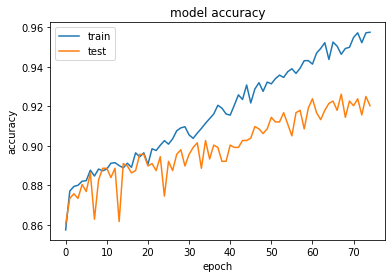

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

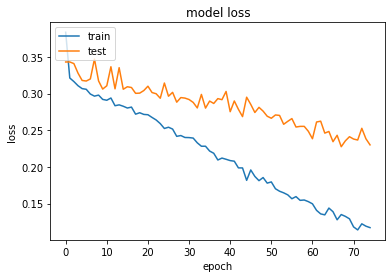

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model.evaluate(X_test, Y_test, verbose=2)

34/34 - 0s - loss: 0.2090 - accuracy: 0.9278 - 132ms/epoch - 4ms/step


[0.20897085964679718, 0.9277673363685608]

<AxesSubplot:>

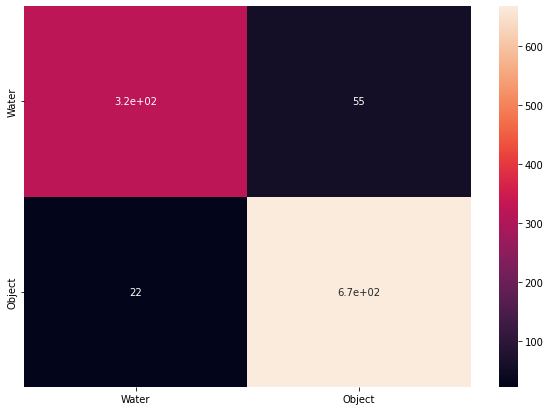

In [12]:
# confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
cm = confusion_matrix([np.argmax(a) for a in Y_test], [np.argmax(a) for a in Y_pred])

df_cm = pd.DataFrame(cm, index=["Water", "Object"], columns=["Water", "Object"])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)

In [13]:
def plot_windmills(left_top_coord, size=(1200, 800), intensity=1):
    (img_h, img_w) = size
    left_top_x, left_top_y = dataset_raw.index(left_top_coord[0], left_top_coord[1])
    needles = []
    step_size = 15

    x_count = ((img_h - block_size) // step_size)
    for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
        for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
            cc = dataset_raw.transform * (yy, xx)
            lx, ly = dataset_land.index(cc[0], cc[1])
            if img_land[lx, ly] != 1:
                continue
            needles.append({'lon': cc[0], 'lat': cc[1]})

    test_images = np.stack([get_processed_image(coord) for coord in needles])
    results = model.predict(test_images)

    from matplotlib import pyplot as plt

    search_space = np.copy(img_raw[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
    search_space = search_space ** (1 / 4)
    highlight = np.max(search_space) * 0.75 * intensity

    found = 0
    previous_i = 0
    coords = []
    found_i = []
    for i, result in enumerate(results):
        if result[1] > result[0]:
            if i - previous_i <= 2:
                continue
            if i - x_count in found_i or (i - (x_count * 2)) in found_i or (i + 1 - x_count) in found_i or (
                    i - 1 - x_count) in found_i:
                continue
            found += 1
            previous_i = i
            found_i.append(i)
            coord = needles[i]
            xx, yy = dataset_raw.index(coord['lon'], coord['lat'])
            xx -= left_top_x
            yy -= left_top_y

            search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
            search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
            search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            coords.append(coord)

    print("found {} windmills".format(found))

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(search_space)

    return coords

found 53 windmills


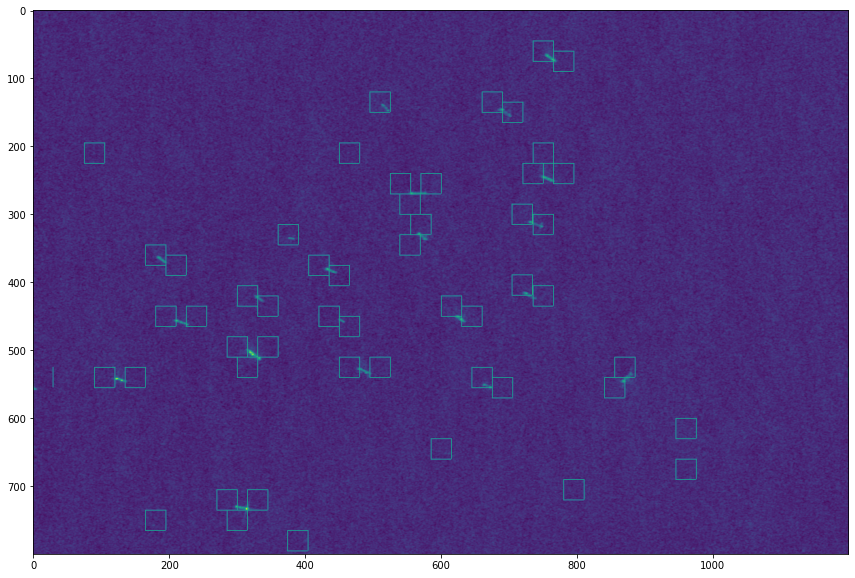

In [14]:
# vb boten
_ = plot_windmills((2.56834, 51.48205))

found 122 windmills


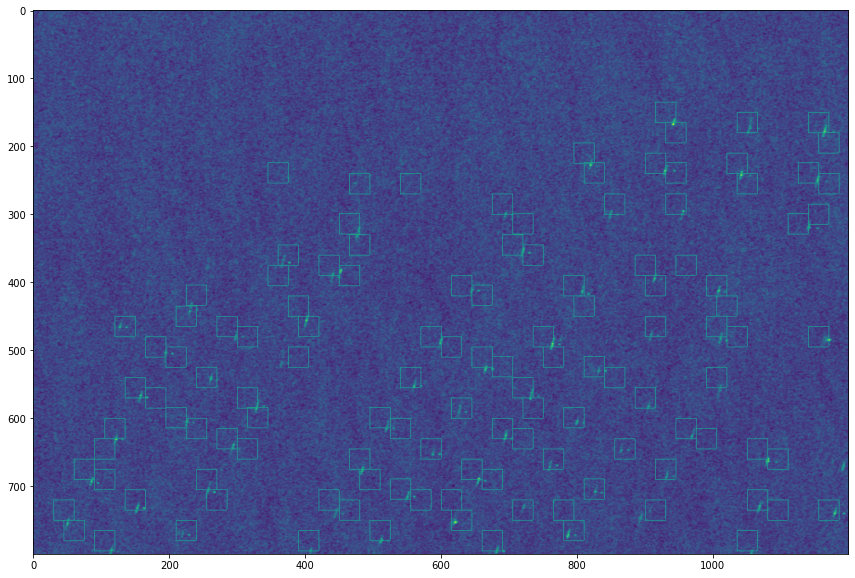

In [15]:
# vb molens
_ = plot_windmills((1.85730, 52.01960))

found 7 windmills


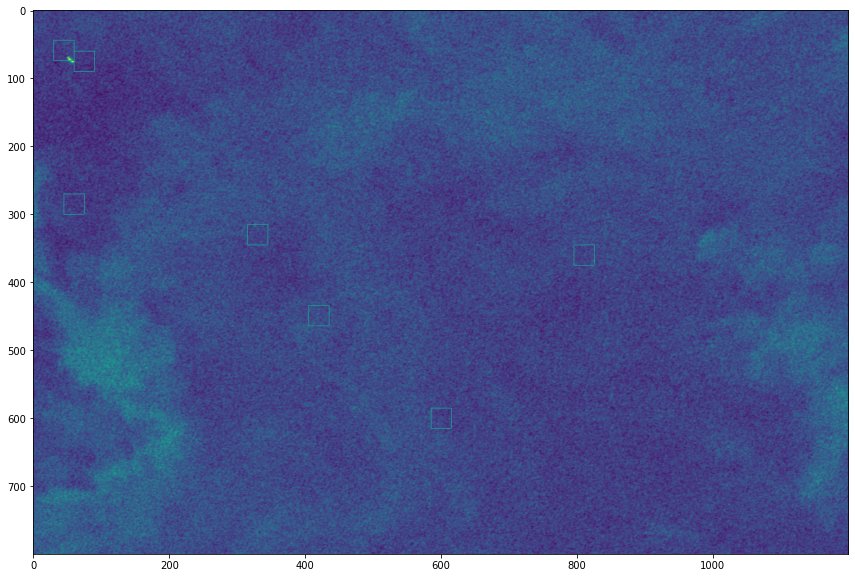

In [16]:
# vb water
_ = plot_windmills((1.57102,52.95992))

found 0 windmills


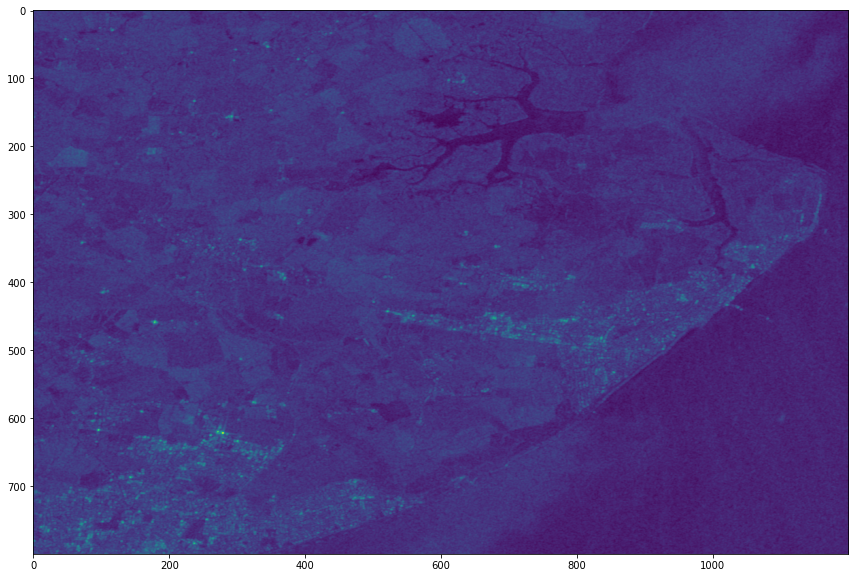

In [17]:
# vb kust
_ = plot_windmills((1.12835, 51.90720))

In [19]:

from functions.image import get_training_img


def detect_windmills():
    needles = []
    step_size = 15

    [h, w] = dataset_raw.shape
    x_count = ((h - block_size) // step_size)
    for xx in range(block_size // 2, h - block_size // 2, step_size):
        for yy in range(block_size // 2, w - block_size // 2, step_size):
            if img_raw[xx, yy] == 0:
                continue
            cc = dataset_raw.transform * (yy, xx)
            lx, ly = dataset_land.index(cc[0], cc[1])
            if img_land[lx, ly] != 1:
                continue
            needles.append((cc[0], cc[1]))

    test_images = np.stack([get_training_img(coord, block_size, img_raw, dataset_raw) for coord in needles])
    results = model.predict(test_images)
    coords = []
    found = 0
    previous_i = 0
    found_i = []
    for i, result in enumerate(results):
        if i - previous_i <= 2:
            continue
        if i - x_count in found_i or (i - (x_count * 2)) in found_i or (i + 1 - x_count) in found_i or (
                i - 1 - x_count) in found_i:
            continue
        found += 1
        previous_i = i
        found_i.append(i)
        if i % 1000 == 0:
            print(f"{i}/{len(results)}")
        if result[1] > result[0]:
            coords.append(needles[i])
    return coords


coords = detect_windmills()
print(len(coords))

2021-12-15 11:26:01.076517: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2849814000 exceeds 10% of free system memory.
2021-12-15 11:26:02.922835: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2849814000 exceeds 10% of free system memory.


2000/791615
4000/791615
6000/791615
8000/791615
29000/791615
31000/791615
33000/791615
35000/791615
37000/791615
58000/791615
60000/791615
62000/791615
64000/791615
66000/791615
87000/791615
89000/791615
91000/791615
93000/791615
95000/791615
116000/791615
118000/791615
120000/791615
122000/791615
124000/791615
145000/791615
147000/791615
149000/791615
151000/791615
153000/791615
174000/791615
176000/791615
178000/791615
180000/791615
182000/791615
203000/791615
205000/791615
207000/791615
209000/791615
230000/791615
232000/791615
234000/791615
236000/791615
238000/791615
259000/791615
261000/791615
263000/791615
265000/791615
267000/791615
288000/791615
290000/791615
292000/791615
294000/791615
296000/791615
317000/791615
319000/791615
321000/791615
323000/791615
325000/791615
346000/791615
348000/791615
350000/791615
352000/791615
354000/791615
375000/791615
377000/791615
379000/791615
381000/791615
383000/791615
404000/791615
406000/791615
408000/791615
410000/791615
412000/791615
4

In [20]:
import json

with open("./data/coords.json", "w+") as f:
    f.write(json.dumps({"coords": coords}))